In [1]:
#Setting up Colab Spark env
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import files
files.upload()

Saving YearPredictionMSD.csv to YearPredictionMSD.csv


In [ ]:
# spark.stop()
!pip install pyspark

     |████████████████████████████████| 212.3MB 73kB/s 
     |████████████████████████████████| 204kB 45.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=5b8d09616491c2b28fb2830fb98ddb330e825ceaa5aa89514fdeb812b42ed378
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
!pip install ipython-autotime

%load_ext autotime

time: 154 µs (started: 2021-05-05 01:45:14 +00:00)


In [ ]:
data = spark.read.csv('YearPredictionMSD.csv', header=False, inferSchema=True)

time: 19.2 s (started: 2021-05-05 01:45:29 +00:00)


In [ ]:
#DATA Preprocess before Feature extraction and Training
data = data.dropna(how='any')

time: 155 ms (started: 2021-05-05 01:46:18 +00:00)


In [ ]:
feature_cols = data.columns[1:13] 
from pyspark.ml.feature import VectorAssembler
vect_assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")

time: 259 ms (started: 2021-05-05 01:46:20 +00:00)


In [ ]:
data_w_features = vect_assembler.transform(data)
data_w_features = data_w_features.withColumnRenamed("_c0", "label")
finalized_data = data_w_features.select("features","label")

time: 354 ms (started: 2021-05-05 01:46:21 +00:00)


In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(finalized_data)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(finalized_data)
scaledData = scaledData.select("scaledFeatures","label")

time: 17.7 s (started: 2021-05-05 01:46:22 +00:00)


In [ ]:
#Split the data into training and test model with 70% obs. going in training and 30% in testing
train_dataset, test_dataset = scaledData.randomSplit([0.7, 0.3], seed = 12345)

time: 35.2 ms (started: 2021-05-05 01:47:02 +00:00)


In [ ]:
#Multiple Linear Regression
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="label")

time: 82.5 ms (started: 2021-05-05 01:47:03 +00:00)


In [ ]:
#Train the model on the training using fit() method.
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])
             .addGrid(lr.maxIter, [100])
             .build())

# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
lrevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
lrcv = CrossValidator(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator = lrevaluator,
                           numFolds=2)
# Run cross validations
lrcvModel = lrcv.fit(train_dataset)
print(lrcvModel)

# Get Model Summary Statistics
lrcvSummary = lrcvModel.bestModel.summary
print("Coefficient Standard Errors: " + str(lrcvSummary.coefficientStandardErrors))

# Use test set here so we can measure the accuracy of our model on new data
lrpredictions = lrcvModel.transform(test_dataset)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('r2:', lrevaluator.evaluate(lrpredictions))

CrossValidatorModel_ea5251f842c5
Coefficient Standard Errors: [0.023517121090784812, 0.023016546136526518, 0.01903108559332277, 0.0316383313508529, 0.018386718647034225, 0.030244989315118678, 0.024834987700612408, 0.02121953599424227, 0.020600547372963005, 0.024633426594017446, 0.029686825045265545, 0.019742345186494318, 0.16949299738739707]
r2: 0.15403117585029535
time: 2min 44s (started: 2021-05-05 02:53:29 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


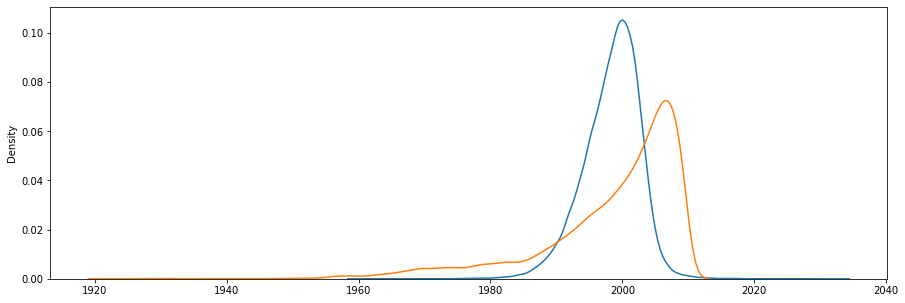

time: 42.2 s (started: 2021-05-05 01:49:59 +00:00)


In [ ]:
# lrpredictions.show()
import matplotlib.pyplot as plt
import seaborn as sns
# dtlrpredictions.show()
prediction = [lrpredictions.select('prediction').collect()]
label = [lrpredictions.select('label').collect()]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

sns.distplot(prediction, kde=True, ax = ax, hist=False, bins = 10)
sns.distplot(label, kde=True, ax = ax, hist=False, bins = 10)

plt.show()

In [ ]:
#Decision Tree Linear Regression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dtlr = DecisionTreeRegressor(featuresCol="scaledFeatures", labelCol="label")

time: 28.7 ms (started: 2021-05-05 01:51:01 +00:00)


In [ ]:
#Train the model on the training using fit() method.
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

dtparamGrid = (ParamGridBuilder()
             .addGrid(dtlr.maxDepth, [5, 10])
             .addGrid(dtlr.maxBins, [5, 10])
             .build())

# In this case the estimator is decision tree linear regression.
dtlrevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
dtlrcv = CrossValidator(estimator=dtlr,
                           estimatorParamMaps=dtparamGrid,
                           evaluator = dtlrevaluator,
                           numFolds=2)
# Run cross validations
dtlrcvModel = dtlrcv.fit(train_dataset)
print(dtlrcvModel)

# Use test set here so we can measure the accuracy of our model on new data
dtlrpredictions = dtlrcvModel.transform(test_dataset)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('r2:', dtlrevaluator.evaluate(dtlrpredictions))

CrossValidatorModel_20f856c30372
r2: 0.18140298861849613
time: 2min 45s (started: 2021-05-05 01:51:02 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


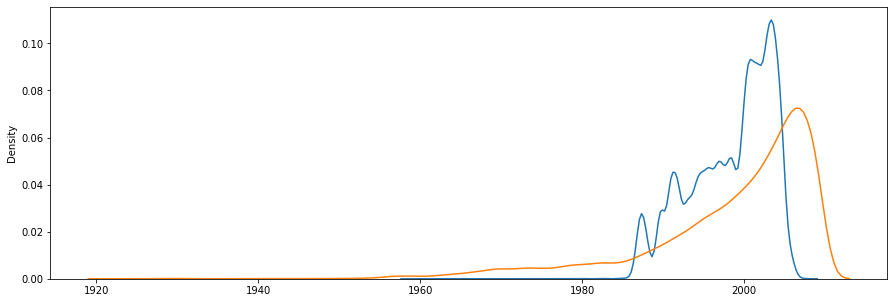

time: 39.9 s (started: 2021-05-05 01:55:59 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# dtlrpredictions.show()
prediction = [dtlrpredictions.select('prediction').collect()]
label = [dtlrpredictions.select('label').collect()]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

sns.distplot(prediction, kde=True, ax = ax, hist=False, bins = 10)
sns.distplot(label, kde=True, ax = ax, hist=False, bins = 10)

plt.show()

In [ ]:
#Random Forest Regression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
rflr = RandomForestRegressor(labelCol="label", featuresCol="scaledFeatures")

time: 24 ms (started: 2021-05-05 01:57:09 +00:00)


In [ ]:
rfparamGrid = (ParamGridBuilder()
               .addGrid(rflr.maxDepth, [5, 10])
               .addGrid(rflr.maxBins, [5, 10])
               .addGrid(rflr.numTrees, [5, 20])
             .build())

# In this case the estimator is random forest regression.
rflrevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
rflrcv = CrossValidator(estimator = rflr,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rflrevaluator,
                      numFolds = 2)
# Run cross validations
rflrcvModel = rflrcv.fit(train_dataset)
print(rflrcvModel)

# Use test set here so we can measure the accuracy of our model on new data
rflrpredictions = rflrcvModel.transform(test_dataset)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('r2:', rflrevaluator.evaluate(rflrpredictions))

CrossValidatorModel_1ac8e56ffe1c
r2: 0.1983566132524076
time: 4min 9s (started: 2021-05-05 01:57:11 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


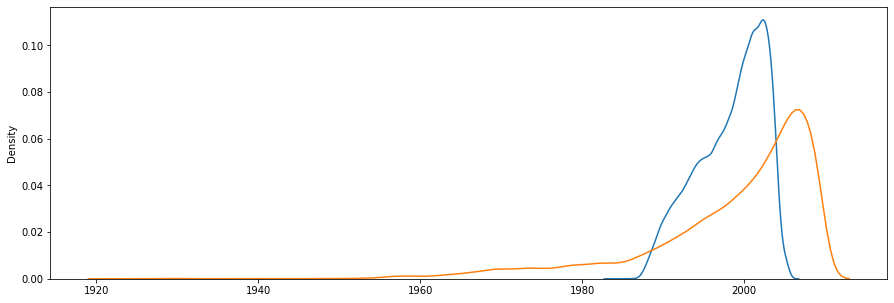

time: 28.7 s (started: 2021-05-05 02:02:47 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# rflrpredictions.show()
prediction = [rflrpredictions.select('prediction').collect()]
label = [rflrpredictions.select('label').collect()]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

sns.distplot(prediction, kde=True, ax = ax, hist=False, bins = 10)
sns.distplot(label, kde=True, ax = ax, hist=False, bins = 10)

plt.show()

In [ ]:
#Gradient Boost Tree Regression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
gbtlr = GBTRegressor(labelCol="label",featuresCol="scaledFeatures")

time: 26 ms (started: 2021-05-05 02:06:49 +00:00)


In [ ]:
gbtparamGrid = (ParamGridBuilder()
  .addGrid(gbtlr.maxDepth, [5, 10])
  .build())

# In this case the estimator is gradient boost tree regression.
gbtlrevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
gbtlrcv = CrossValidator(estimator = gbtlr,
                      estimatorParamMaps = gbtparamGrid,
                      evaluator = gbtlrevaluator,
                      numFolds = 2)
# Run cross validations
gbtlrcvModel = gbtlrcv.fit(train_dataset)
print(gbtlrcvModel)

# Use test set here so we can measure the accuracy of our model on new data
gbtlrpredictions = gbtlrcvModel.transform(test_dataset)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('r2:', gbtlrevaluator.evaluate(gbtlrpredictions))


CrossValidatorModel_21f143905311
r2: 0.19260166718645888
time: 4min 16s (started: 2021-05-05 02:06:51 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


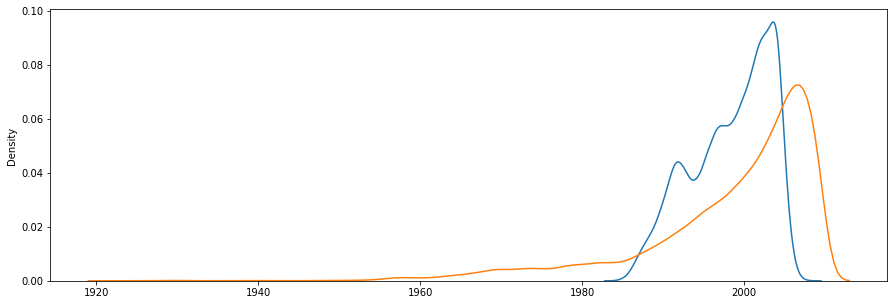

time: 28 s (started: 2021-05-05 02:12:32 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# gbtlrpredictions.show()
prediction = [gbtlrpredictions.select('prediction').collect()]
label = [gbtlrpredictions.select('label').collect()]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

sns.distplot(prediction, kde=True, ax = ax, hist=False, bins = 10)
sns.distplot(label, kde=True, ax = ax, hist=False, bins = 10)

plt.show()